In [ ]:
import pandas as pd
import requests
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed, wait
import os

# File paths
input_csv = 'chembl_drug_docs.csv'
output_csv = 'drug_docs_with_refs.csv'

# Load full input CSV
df = pd.read_csv(input_csv)

In [3]:
def get_references(doi):
    if pd.isna(doi):
        return ''
    try:
        response = requests.get(f'https://api.crossref.org/works/{doi}', timeout=10)
        if response.status_code == 200:
            data = response.json()
            refs = data.get('message', {}).get('reference', [])
            dois = [ref.get('DOI') for ref in refs if ref.get('DOI')]
            return ' '.join(dois)
    except:
        return ''
    return ''

def process_row(idx, doi):
    return idx, get_references(doi)

In [4]:
# response = requests.get(f'https://api.crossref.org/works/{doi}', timeout=10)
df.iloc[0]

molregno                                                   97
doc_id                                                   7244
doc_type                                          PUBLICATION
doi                                       10.1021/jm00143a012
title       Synthesis and antihypertensive activity of a s...
year                                                   1981.0
Name: 0, dtype: object

In [5]:
from math import ceil

batch_size = 200

# Detect existing output CSV to resume
if os.path.exists(output_csv):
    df_out = pd.read_csv(output_csv)
    start_row = len(df_out)
    print(f"Resuming from row {start_row}")
else:
    df_out = pd.DataFrame(columns=df.columns.tolist() + ['references'])
    start_row = 0
    print("Starting from row 0")

num_rows = len(df)
num_batches = (num_rows + batch_size - 1) // batch_size

pbar = tqdm(total=num_rows, initial=start_row, unit='rows')

for batch_start in range(start_row, num_rows, batch_size):
    batch_end = min(batch_start + batch_size, num_rows)
    batch_rows = df.iloc[batch_start:batch_end]

    results = []

    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(process_row, i, doi) for i, doi in zip(batch_rows.index, batch_rows['doi'])]
        for future in as_completed(futures):
            results.append(future.result())
            pbar.update(1)

    # Update DataFrame
    for idx, refs in results:
        df.at[idx, 'references'] = refs

    # Append batch to output CSV
    df_batch = df.iloc[batch_start:batch_end].copy()
    if start_row == 0 and batch_start == 0:
        df_batch.to_csv(output_csv, index=False)
    else:
        df_batch.to_csv(output_csv, index=False, mode='a', header=False)

    # print(f"Saved rows {batch_start}-{batch_end-1}")

pbar.close()

Resuming from row 200243


100%|##########| 200243/200243 [00:00<?, ?rows/s]

In [6]:
# for doi_1 in df['doi']:
#     response = requests.get(f'https://api.crossref.org/works/{doi_1}', timeout=10)
#     try:
#         abstract = response.json()['message'].get('abstract', '')
#     except JSONDecodeError:
#         continue
#     if abstract:
#         print(doi_1)
#         print(abstract)

In [7]:
# Load patterns from hit_synonyms.txt
with open('hit_synonyms.txt', 'r') as f:
    patterns = [line.strip() for line in f if line.strip()]

# Create pattern names by removing \b boundaries
pattern_names = [pattern.replace('\\b', '') for pattern in patterns]

print(f"Loaded {len(patterns)} patterns.")

Loaded 11 patterns.


In [8]:
patterns

['\\bhigh[\\s-]?throughput\\b',
 '\\bHTS\\b',
 '\\bscreen(ing|ed|s)?\\b',
 '\\bhit(s)?\\b',
 '\\bidentification\\b',
 '\\boptimi(s|z)ation\\b',
 '\\bseries\\b',
 '\\bcompound\\b',
 '\\bcandidates?\\b',
 '\\bfragment\\b',
 '\\bphenotyp(e|ic)\\b']

In [9]:
import duckdb
import re

# Create regex pattern
combined_pattern = '|'.join(patterns)

# Load data into DuckDB
conn = duckdb.connect()
conn.execute("CREATE TABLE papers AS SELECT * FROM read_csv_auto('drug_docs_with_refs.csv')")

# Find citation pairs
query = f"""
SELECT DISTINCT 
    hit_paper.molregno as molregno,
    hit_paper.doi as hit_paper,
    hit_paper.title as hit_title,
    drg_paper.doi as drug_paper,
    drg_paper.title as drug_title
FROM papers drg_paper
JOIN papers hit_paper ON drg_paper.references LIKE '%' || hit_paper.doi || '%'
WHERE regexp_matches(hit_paper.title, '{combined_pattern}', 'i')
    AND drg_paper.doi != hit_paper.doi
    AND drg_paper.molregno == hit_paper.molregno
ORDER BY hit_paper.molregno
"""

citation_pairs = conn.execute(query).df()
print(f'Found {len(citation_pairs)} citation pairs')
citation_pairs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Found 12535 citation pairs


,molregno,hit_paper,hit_title,drug_paper,drug_title
0,97,10.1016/j.bmcl.2014.02.066,Evaluation of structural effects on 5-HT(2A) r...,10.1016/j.bmcl.2015.10.012,Synthesis and evaluation of aporphine analogs ...
1,97,10.1021/jm7015683,Prediction and identification of drug interact...,10.1021/jm8003152,Structural requirements for drug inhibition of...
2,97,10.1021/jm980285e,Synthesis and structure-activity relationships...,10.1016/j.ejmech.2011.04.032,"Discovery of LASSBio-772, a 1,3-benzodioxole N..."
3,97,10.1021/jm0307842,Alpha1-adrenoceptor antagonists. 6. Structural...,10.1016/j.bmcl.2008.07.084,Synthesis and biological affinity of new imida...
4,97,10.1021/jm7015683,Prediction and identification of drug interact...,10.1021/jm300212s,Classification of inhibitors of hepatic organi...
...,...,...,...,...,...
12530,2755078,10.1021/acs.jmedchem.2c00117,"Discovery of S-217622, a Noncovalent Oral SARS...",10.1021/acs.jmedchem.2c01146,Discovery and Crystallographic Studies of Tris...
12531,2755078,10.1021/acs.jmedchem.2c00117,"Discovery of S-217622, a Noncovalent Oral SARS...",10.1021/acsmedchemlett.3c00335,"Design and Optimization of Novel Competitive, ..."
12532,2755078,10.1021/acs.jmedchem.2c00117,"Discovery of S-217622, a Noncovalent Oral SARS...",10.1021/acsmedchemlett.2c00349,"Oral Nonpeptidic, Noncovalent Triazine Coronav..."
12533,2755078,10.1021/acs.jmedchem.2c00117,"Discovery of S-217622, a Noncovalent Oral SARS...",10.1016/j.ejmech.2023.115503,Bench-to-bedside: Innovation of small molecule...


In [15]:
pattern_names = [f"pattern_{i+1}" for i in range(len(patterns))]

# Convert citation_pairs to DataFrame
df_pairs = pd.DataFrame(citation_pairs)[['hit_title']]

# Create an in-memory DuckDB connection
con = duckdb.connect()

# Register tables
con.register("titles", df_pairs)
con.register("patterns", pd.DataFrame({"pattern": patterns, "pattern_name": pattern_names}))

# SQL implementing Approach 2 using a cross join over the Python-supplied pattern list
query = """
SELECT 
    p.pattern[3:-3] AS pattern,
    COUNT(*) FILTER (WHERE REGEXP_MATCHES(titles.hit_title, '(?i)' || p.pattern)) AS count_in_pairs,
    COUNT(DISTINCT titles.hit_title) FILTER (WHERE REGEXP_MATCHES(titles.hit_title, '(?i)' || p.pattern)) AS count_in_unique_titles
FROM titles
CROSS JOIN patterns p
GROUP BY p.pattern
"""

results_df = con.execute(query).fetch_df()

# Add the total row exactly like your original code
total_row = pd.DataFrame({
    'pattern': ['total'],
    'count_in_pairs': [results_df['count_in_pairs'].sum()],
    'count_in_unique_titles': [results_df['count_in_unique_titles'].sum()]
})

results_df = pd.concat([results_df, total_row], ignore_index=True).sort_values(
    by='count_in_unique_titles', ascending=False
)

print(results_df.to_string(index=False))


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

             pattern  count_in_pairs  count_in_unique_titles
               total           14440                    2620
              series            3642                     688
      identification            3694                     660
    optimi(s|z)ation            2390                     470
   screen(ing|ed|s)?            1721                     321
         candidates?            1115                     199
            fragment             414                      88
            compound             387                      66
             hit(s)?             360                      61
high[\s-]?throughput             622                      41
      phenotyp(e|ic)              60                      19
                 HTS              35                       7


In [ ]:
# # Analyze pattern matches using pandas
# import re

# # Convert to DataFrame and count matches
# df_pairs = pd.DataFrame(citation_pairs)['hit_title']
# df_pairs_unique = pd.Series(list(set(df_pairs)))
# pattern_counts = []
# pattern_counts_unique = []

# for i, pattern in enumerate(patterns):
#     count = df_pairs.str.contains(pattern, case=False, regex=True, na=False).sum()
#     count_unique = df_pairs_unique.str.contains(pattern, case=False, regex=True, na=False).sum()
#     pattern_counts.append([pattern_names[i], count, count_unique])

# results_df = pd.DataFrame(pattern_counts, columns=['pattern', 'count_in_pairs', 'count_in_unique_titles'])

# # Add total row
# total_row = pd.DataFrame({
#     'pattern': ['total'],
#     'count_in_pairs': [results_df['count_in_pairs'].sum()],
#     'count_in_unique_titles': [results_df['count_in_unique_titles'].sum()]
# })

# results_df = pd.concat([results_df, total_row], ignore_index=True).sort_values(by='count_in_unique_titles', ascending=False)

# # Display results
# print('Pattern match counts in citation pairs:')
# print(results_df.to_string(index=False))


C:\Users\legit\AppData\Local\Temp\ipykernel_13928\2316501886.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count = df_pairs.str.contains(pattern, case=False, regex=True, na=False).sum()
C:\Users\legit\AppData\Local\Temp\ipykernel_13928\2316501886.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count_unique = df_pairs_unique.str.contains(pattern, case=False, regex=True, na=False).sum()


Pattern match counts in citation pairs:
             pattern  count_in_pairs  count_in_unique_titles
               total           14440                    2620
              series            3642                     688
      identification            3694                     660
    optimi(s|z)ation            2390                     470
   screen(ing|ed|s)?            1721                     321
         candidates?            1115                     199
            fragment             414                      88
            compound             387                      66
             hit(s)?             360                      61
high[\s-]?throughput             622                      41
      phenotyp(e|ic)              60                      19
                 HTS              35                       7


C:\Users\legit\AppData\Local\Temp\ipykernel_22828\2984077494.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkblue')
C:\Users\legit\AppData\Local\Temp\ipykernel_22828\2984077494.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkred')


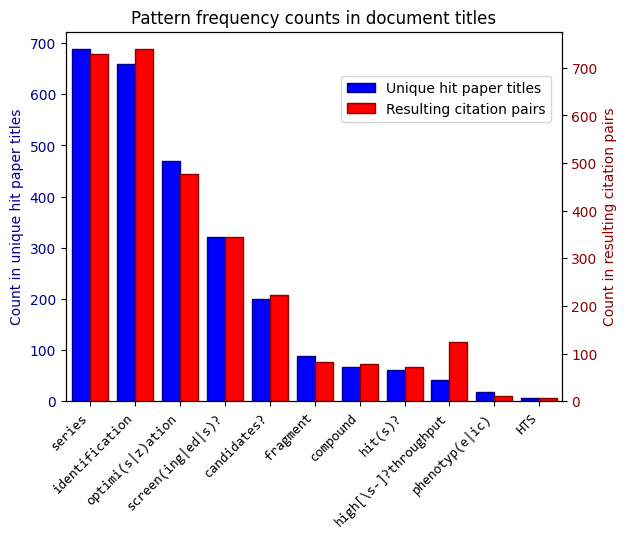

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure() # Create matplotlib figure

ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

results_df[1:].count_in_unique_titles.plot(kind='bar', color='blue', edgecolor='darkblue', ax=ax1, width=width, position=1)
results_df[1:].count_in_pairs.plot(kind='bar', color='red', edgecolor='darkred', ax=ax2, width=width, position=0)

plt.title('Pattern frequency counts in document titles')
fig.legend(['Unique hit paper titles', 'Resulting citation pairs'], borderaxespad=5.5)
ax1.set_xticklabels(results_df[1:].pattern, rotation=45, ha='right', fontdict={'font': 'Consolas'})

ax1.set_ylabel('Count in unique hit paper titles', color='darkblue')
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkblue')
ax2.set_ylabel('Count in resulting citation pairs', color='darkred')
ax2.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkred')

ax1.set_xlim(-0.55, len(results_df[1:]) - 0.5)
plt.show()

In [17]:
count_patterns = lambda title: sum(1 for pattern in patterns if pd.Series([title]).str.contains(pattern, case=False, regex=True, na=False).iloc[0])

# Add column counting pattern matches in hit_title
citation_pairs['pattern_count'] = citation_pairs['hit_title'].apply(
    count_patterns
)

pattern_count_unique = pd.Series(citation_pairs['hit_title'].unique()).apply(
    count_patterns
)

C:\Users\legit\AppData\Local\Temp\ipykernel_22828\2111510102.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count_patterns = lambda title: sum(1 for pattern in patterns if pd.Series([title]).str.contains(pattern, case=False, regex=True, na=False).iloc[0])
C:\Users\legit\AppData\Local\Temp\ipykernel_22828\2111510102.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count_patterns = lambda title: sum(1 for pattern in patterns if pd.Series([title]).str.contains(pattern, case=False, regex=True, na=False).iloc[0])


In [18]:
print(f"Pattern count distribution:")
count_df = pd.DataFrame({'Row counts': 
                    citation_pairs['pattern_count'].value_counts().sort_index(ascending=True), 
                    'Unique counts': 
                    pattern_count_unique.value_counts().sort_index(ascending=True)
                    })
print(count_df)

Pattern count distribution:
   Row counts  Unique counts
1       10943           1996
2        1306            217
3         260             55
4          25              5
5           1              1


C:\Users\legit\AppData\Local\Temp\ipykernel_22828\1887206970.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkblue')
C:\Users\legit\AppData\Local\Temp\ipykernel_22828\1887206970.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkred')


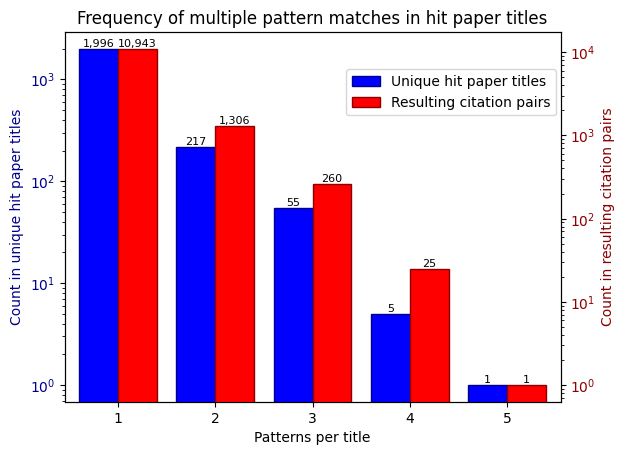

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure() # Create matplotlib figure

ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

count_df['Unique counts'].plot(kind='bar', color='blue', edgecolor='darkblue', ax=ax1, width=width, position=1)
count_df['Row counts'].plot(kind='bar', color='red', edgecolor='darkred', ax=ax2, width=width, position=0)

plt.title('Frequency of multiple pattern matches in hit paper titles')
fig.legend(['Unique hit paper titles', 'Resulting citation pairs'], borderaxespad=5.0, loc='upper right')

ax1.set_ylabel('Count in unique hit paper titles', color='darkblue')
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkblue')
ax2.set_ylabel('Count in resulting citation pairs', color='darkred')
ax2.set_yticklabels([int(x) for x in ax1.get_yticks()], color='darkred')

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel('Patterns per title')

for idx, rect in enumerate(ax1.patches):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=8)
for idx, rect in enumerate(ax2.patches):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=8)

ax1.set_xlim(-0.55, len(count_df) - 0.45)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()


In [20]:
import duckdb

# Write citation pairs to CSV using DuckDB
try:
    citation_pairs.sort_values('pattern_count', ascending=False).to_csv('citation_pairs.csv', index=False)
except PermissionError:
    class MoronError(Exception):
        pass
    raise MoronError("Close Excel you dummy")

In [21]:

# Import required libraries
import pandas as pd

# Read the citation_pairs data
citation_pairs = pd.read_csv('citation_pairs.csv')

# Count unique molregno values
unique_molregno_count = citation_pairs['molregno'].nunique()

# Print the count
print(f"Number of unique molregno: {unique_molregno_count}")

Number of unique molregno: 1215


In [22]:
# Output both doc IDs on citation_pairs
# Apply patterns to abstracts as well